# <span style="color:#3498db">**Univariate TFR statistics, a mini-tutorial**</span>


Specifically, to assess the statistical significance of spectral estimates obtained from electrophysiological data (in this case LFP) we used non-parametric permutation tests and focused on the multiple comparison correction of time frequency representations (TFRs). We show that the success of the two approaches depends on the dimensions of the data at hand, be these spatial locations, time and frequency analysis parameters, trials of different conditions, the nature of hypothesis, etc. For basic pedagogical purposes, here I focus on spectral power increases relative to baseline using two variants of essentially the same approach: 1) null hypothesis testing using the min-max distribution approach, which captures variations at the extremes of the null distribution, and 2) null hypothesis testing using the whole null distribution, obtained by averaging across specific dimensions.

Since there are several ways to achieve these goals and many realizations of these and other related methods (i.e. thresholds may be obtained from the percentiles of the null distribution directly and further corrected in equivalent ways, or the pooling of data accomplished among specific dimensions), here I focus on these two common methods using very simple examples in the hope to help those researchers (including myself) that are or may be in need of clarity on these matters, touch ground. Depending on the approach, the computation of the p-values will change slightly. In the min-max approach the minimum and maximum values at each permutations are used. When testing using the whole null distribution, the null values obtained from the permutations are averaged the same way the empirical distribution is averaged so the dimensions of the empirical distributions are preserved in the null distribution. Once the null distributions have been obtained, p-values are obtained using the empirical cumulative distribution. Provided the right Python environment, this Jupyter notebook should work as a simple mini-tutorial and support the discussion of these and related basic approaches for computing TFRs and assessing their statistical significance in a clear way. The methods presented here are a work in progress. I plan to make some refinements in the next few weeks. Should you be interested in  employing these methods or if you have any questions, please feel free to reach out to me. I would be more than happy to assist you further.

The package can be downloaded from here: https://github.com/nicogravel/tfrStats

Then we need to load the module with the functions we want to use and define the paths. 

## Statistical thresholds overlaid onto spatio-temporal frequency maps

Here we plot TFRs with the significance threshold computed from p-values (i.e. p-val <= 0.05) (top panel, blue trace). The alpha mask specifies the section containing the values above the null percentile cutoff (i.e. 95%). The p-values (bottom panel) with the null percentile cutoff  (red trace). We do so for spectral power as a function of frequency, space and time. For spatial TFR one must consider the pooling of data over predefined frequency bins, as well as spatial dimentions (i.e.  ROIs). Therefore, the multiple correction will change slightly. 

In [1]:
from tfrStats.plot_tfr_stats import plot_tfr_stats as plot_tfr_stats
from tfrStats.plot_dtfr_stats import plot_dtfr_stats as plot_dtfr_stats

#in_path   = '/Volumes/.../data/'
#out_path  = '/Volumes/.../results/stats/univariate/'
in_path   = '/Volumes/Gandalf/MWlamprop/data/'
out_path  = '/Volumes/Gandalf/MWlamprop/results/stats/univariate/'
paths     = [in_path,out_path]

type         = 'minmax'
null         = [95, 0.05] # percentile, p-value
fband        = 1; 
cond         = 0

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_1000_minmax.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (1000, 30, 12, 16, 2)
min-max
cutoff computed using min/max of null distribution:  75.96054268486813


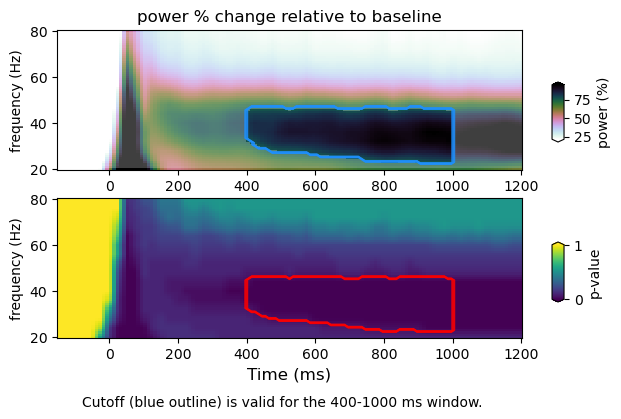

In [5]:

# Time-frequency map
TFR_emp, significant, THR = plot_tfr_stats(out_path, cond, fband, null, type)  

In [8]:
print(ax)
plt.show()

[<AxesSubplot:title={'center':'power % change relative to baseline'}, ylabel='frequency (Hz)'>
 <AxesSubplot:xlabel='Time (ms)', ylabel='frequency (Hz)'>]


/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_1000_minmax.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (1000, 30, 12, 16, 2)
peak frequency range :  28.0 44.0
power average within peak: 86.6390137791448
min-max
cutoff computed using min/max of null distribution:  70.91082666125475


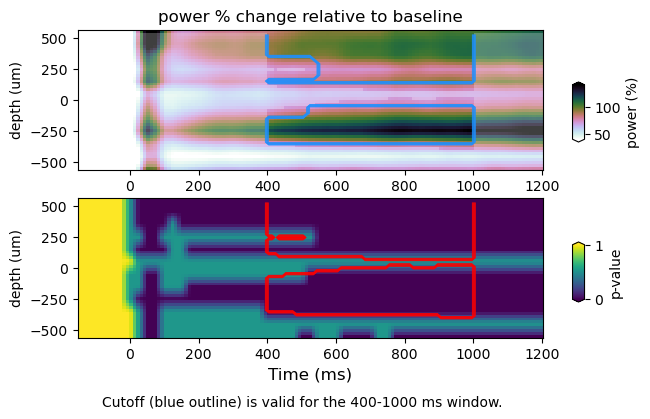

In [4]:
TFR_emp, significant, THR  = plot_dtfr_stats(out_path, cond, fband, null, type)  